# Job Posting Crawler

This is code that will pull each job posting for a specific job title (currently just Data Scientist) in a specific location (or Nationally) and return / plot the percentage of the postings that have certain user-defined keywords that are passed to the code.  

NOTE:  I got this idea from https://jessesw.com/Data-Science-Skills/.  Obviously, just using his code would be of no real benefit to me, as I wanted to use the idea to help better my skills with scraping data from HTML files.  So, I used his idea and developed my own code from scratch.  I also modified the overall process a bit to better fit my needs.

In [6]:
from bs4 import BeautifulSoup
import urllib
import re
from time import sleep
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Define the city, state, job title, and keywords to be used

In [7]:
city = 'Seattle'
state = 'WA'
job_title = 'Data Scientist'
# Create a list of key words that we want to search for
keywords_input = ['R','Python','Perl','Hadoop','Hive','Pig','SQL',\
            'Scripting','SAS','Matlab','Oracle','Java','C','Unix',\
            'ML','Scikit','Scikitlearn','pandas','numpy','Octave',\
            'git','Statistics','Spark','Stata','Scala','Machine'] 
## I have 'machine' in the keywords, as all spaces are removed and i wanted to search
## for 'machine learning'.  I need to modify the code to be able to search for multiple
## words in sequence.

Define a function that will take the url and pull out the text of the main body as a list of strings.  Remove common words such as 'the', 'or', 'and', etc.

In [13]:
def clean_the_html(url,keywords):
    # First try to download the html file
    html = urllib.urlopen(url)
    
    #print url
    
    # Open html in BeautifulSoup
    soup = BeautifulSoup(html)
        
    # Extract everything within the <p> tags
    text = soup.findAll('body')
    word_list = ''
    for line in text:
        word_list = ' '.join([word_list,line.get_text(' ',strip=True).lower()])
    
    # Remove non text characters from list
    word_list = re.sub('[^a-zA-Z+3]',' ', word_list)

    list_of_words = word_list.encode('ascii','ignore').split()
               
    keywords_lower = [x.lower() for x in keywords]
    
    stop_words = set(stopwords.words("english"))
    
    # Remove words from list
    truncated_list = [w for w in list_of_words if w in keywords_lower]
    
    truncated_set = set(truncated_list)
    truncated_list = list(truncated_set)
        
    return truncated_list

Define a function to generate a list of urls for a given search (i.e., 'Data Scientist').  Each search result page has 10 non-sponsored links.  Search the first url for 'Jobs # to # of ###' in order to determine how many iterations to perform.

In [31]:
def gen_url_list(city,state,job_name):
    base_url = 'http://www.indeed.com/'
    
    job_term = re.sub(' ','+',job_name.lower())
    
    search_url = ''.join([base_url,'jobs?q=',job_term,'&l=',city,'%2C+',state])
    
    html = urllib.urlopen(search_url)
    
    soup = BeautifulSoup(html)
    
    total_jobs = soup.find(id = 'searchCount').string.encode('utf-8')
    job_nums = int([int(s) for s in total_jobs.split() if s.isdigit()][-1]/10)
    print total_jobs

    job_URLS = []
    for i in range(job_nums):
        if i % 10 == 0:
            print i
        if i > 10:
            print "Debug line to only pull first 100 postings"
            print " "
            print " "
            print " "
            break
        page_url = ''.join([base_url,job_term,'&1=',city,'%2C+',state,\
                            '&start=',str((i+1)*10)])
        html = urllib.urlopen(search_url)
        
        soup = BeautifulSoup(html)
        
        job_link_area = soup.findAll('h2',{'class':'jobtitle'})

        for link in job_link_area:
            match_href = re.search('<a\shref="(.+?)"',str(link))
            if match_href:
                job_URLS.append([base_url + match_href.group(1)])

    return job_URLS

Now that we have a list of all of the URLs of job postings, pull the information from each site, clean the data, and populate the keyword list.

In [32]:
def job_posting_analysis(url_list,keywords):
    job_skills = []
    count = 0
    for url in url_list:
        count += 1
        if count % 10 == 1:
            print count
        
        posting_keywords = clean_the_html(url[0],keywords)
        if posting_keywords:
            job_skills.append(posting_keywords)
        sleep(0.5)
        
    return job_skills

Now that the various functions are defined, run the code.  
    First: run gen_url_list for the specified city, state, and jobtitle in order to generate
    the list of job posting links
    
Second: run job_posting_analysis to pull out the job_skills listed for each job posting.
    job_skills will be the skills that match skills found in the 'keywords_input' variable.

In [33]:
print 'Crawl indeed.com for ' + city + ', ' + state + ' ' + job_title + \
' postings and generate a list of all of the job posting links'

url_list = gen_url_list(city,state,job_title)

print "given the job posting links, pull out the keywords for each posting \
that is found in the provided keywords_input variable"

job_skills = job_posting_analysis(url_list,keywords_input)

Crawl indeed.com for Seattle, WA Data Scientist postings and generate a list of all of the job posting links
Jobs 1 to 10 of 721
0
10
Debug line to only pull first 100 postings
 
 
 
given the job posting links, pull out the keywords for each posting that is found in the provided keywords_input variable
1
11
21
31
41
51
61
71
81
91
101


Now that we have the list of keywords in the job postings, as well as the keywords that we defined previously, calculate the number of postings in which each keyword appears.  Then plot the data on a bar graph

In [34]:
skill_frequency = Counter() # This will create a full counter of our terms. 
[skill_frequency.update(item) for item in job_skills] # List comp
print skill_frequency.items()

[('pig', 66), ('unix', 22), ('sas', 44), ('statistics', 88), ('java', 44), ('hadoop', 66), ('machine', 88), ('matlab', 55), ('stata', 11), ('scikitlearn', 11), ('numpy', 11), ('pandas', 11), ('python', 88), ('git', 11), ('octave', 22), ('sql', 99), ('spark', 22), ('c', 44), ('ml', 11), ('hive', 66), ('r', 99), ('oracle', 22), ('scripting', 55)]


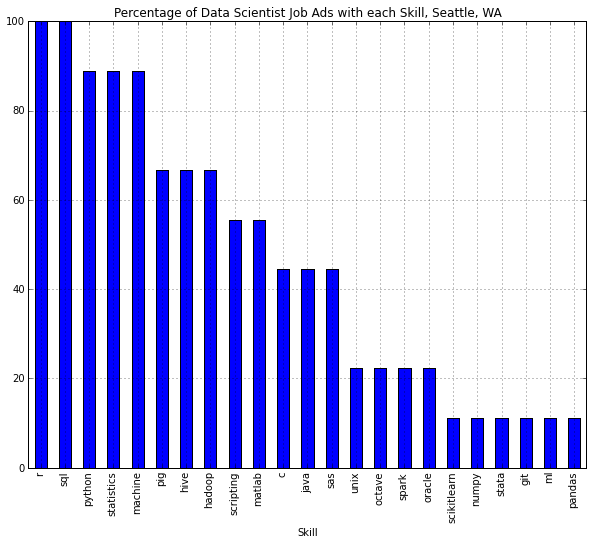

In [35]:
data_to_plot = pd.DataFrame(skill_frequency.items(),columns = ['Skill','Occurances'])

data_to_plot.Occurances = (data_to_plot.Occurances)*100/len(job_skills)

data_to_plot.sort(columns = 'Occurances',ascending = False,inplace = True)

frame = data_to_plot.plot(x='Skill',kind='bar',legend=None,\
                  title='Percentage of Data Scientist Job Ads with each Skill, '\
                  + city + ', ' + state)

fig = frame.get_figure()

In [36]:
filename = '_'.join([city,state,'skills'])
filename = ''.join([filename,'.pdf'])
pp = PdfPages(filename)
pp.savefig(fig)
pp.close()

In [36]:
sample = text_cleaner('http://www.indeed.com/rc/clk?jk=f54117307d3f6805')

NameError: name 'text_cleaner' is not defined

In [10]:
sample[:20]

['operations',
 'knowledgeable',
 'hands',
 'insight',
 'results',
 'feature',
 'performance',
 'scientist',
 'including',
 'solutions',
 'statistical',
 'innovative',
 'jobpowered',
 'decisions',
 'networks',
 'relationships',
 'web',
 'group',
 'knowledge',
 'candidate']

In [11]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 

    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.

    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''

    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)

    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string


    base_url = 'http://www.indeed.com'


    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page

    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this

    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result


    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 

    city_title = city
    if city is None:
        city_title = 'Nationwide'

    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found

    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list

    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each

        html_page = urllib2.urlopen(current_page).read() # Get the page

        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist

        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs

        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS


        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 

    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for

    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})

    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})

    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})


    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects



    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 

    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 

    # Sort the data for plotting purposes

    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot

    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)

    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object


    return fig, final_frame # End of the function

There were 100 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Done with collecting the job postings!
There were 109 jobs successfully found.


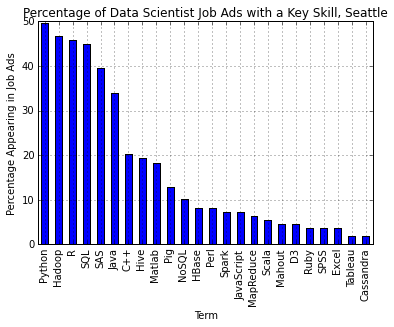

In [24]:
fig, seattle_info = skills_info(city = 'Seattle', state = 'WA') 

In [29]:
pp = PdfPages('Seattle_skills.pdf')
pp.savefig(fig)
pp.close()